<a href="https://colab.research.google.com/github/maciekSzubiczuk/GUM/blob/main/lab2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Using LSTM

# Load The Data

In [ ]:
from urllib.request import urlretrieve
import zipfile


amazon_mobile_reviews_url =  "https://eduds.blob.core.windows.net/nlp/Amazon_Unlocked_Mobile.csv.zip"
filename = "Amazon_Unlocked_Mobile.csv.zip"

urlretrieve(amazon_mobile_reviews_url, filename)

with zipfile.ZipFile("/content/Amazon_Unlocked_Mobile.csv.zip") as zfile:
  zfile.extractall()


In [ ]:
import pandas as pd
df = pd.read_csv("/content/Amazon_Unlocked_Mobile.csv")


In [ ]:
df


***Hint***: work with sample drawn from original dataset. When you complete the code of the lab increase the size of the sample.

# Perform sentiment analysis with  nltk SentimentIntensityAnalyzer

Use library:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Evaluate results:
1. accuracy
2. misclasification matrix

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# EDA and Data Preprocessing

1. Replace   null values in Brand Name with "Unknown" value
2. Find distribution of Rating (plot histogram)
3. Recode Rating  value into Sentiment (Rating >=3 - positive sentiment (1) , Rating  < 3 - negative (0))

# Text preprocessing
1. Change the words into its root words using spacy
2. Remove stopwords (optional)

# Tokenizing



Use Tokenizer to tokenize text

Replace value of oov_token is set to be ‘OOV’. That means any unknown words will be replaced by oov_token.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Padding

Pad sequences to maximal length



In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model Creation


Model:

*   Embedding
*   LSTM (30 units)
*   Dense (2 layers, 2 x relu, last layer-  sigmoid)

Loss function: binary cross entropy , optimizer = 'adam'



Try to  build network like this:

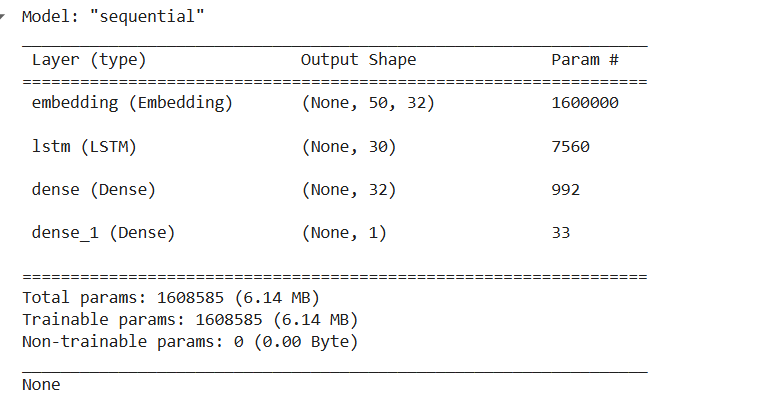

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Split Data into Train and Test

Test: 30% of randomly chosen  observations.
Random Seed: 10

In [ ]:
from sklearn.model_selection import train_test_split

#
#

# fit model

# Model Training

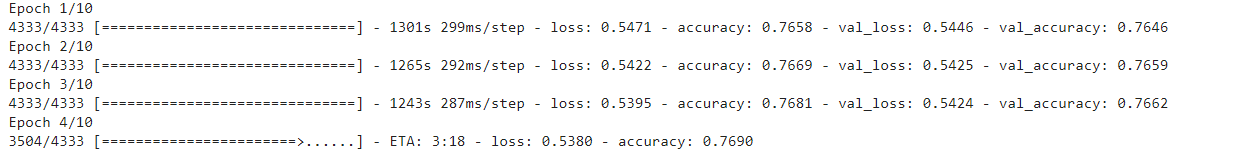

# Performance Metrics and Accuracy

Perform binary prediction on test data set

**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

**Accuracy Score**

In [ ]:
from sklearn.metrics import accuracy_score